# Atividade - Perceptron Multiclasse

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

margem = 0.1
def CriaDataSetClassificacao(n=20, slop=[2,1], intercept=-0.4): 
    #exemplo 1
    #slop=[2,1], intercept=-0.4

    X = np.random.uniform(size=(n,2))
    AUX = np.multiply(X,slop)-[0, intercept]
    y = (AUX[:,0] > X[:,1])*2-1
    
    return X, y

def CriaDataSetRegressao(n=20, slop=0.5, intercept=0.2): 
    #função atualizada na AULA 2
    #exemplo com regressão e apenas uma dimensão
    X = np.random.uniform(size=(n,1)) #n,1 apenas uma dimensão
    AUX = np.random.rand(n,1)-0.5
    
    y = X*slop + intercept + AUX*0.1
    y = y.flatten()
    
    return X, y
    
def CriaDataSetRegularizacao(n=20, slop=[2,1], intercept=-0.4, dummy_features=3): 
    '''
    Dataset para ilustrar regularização no treinamento.
    Criaremos uma base que possui algum ruído proposital para avaliar o comportamento do treinamento com ele.
    '''
    
    X = np.random.uniform(size=(n,dummy_features))
    AUX = np.multiply(X[:,:2],slop)-[0, intercept] # equivalente @, multiplicação de matrizes
    y = np.array(AUX[:,0] > AUX[:,1], dtype=int)*2-1
    
    return X, y

def criaDatasetMulticlasse(n=1000,n_classes=4):
    '''
    Gera uma base de dados para problemas multiclasse (n_classes conforme parâmetro).
    '''
    X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1),cluster_std=0.02)
    return X,y

def criaDatasetXOR(n=1000):
    '''
    Cria dataset XOR, não linearmente separável.
    Será necessária uma camada oculta para resolver. Próxima aula
    '''
    X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
    y = np.array(y%2,dtype=int)
    return X,y

def criaDatasetXOR_Multiclasse(n=20, n_classes=3):
    '''
    Cria dataset XOR, não linearmente separável.
    Mesmo do anterior, mas com varias classes
    '''
    X,y = make_blobs(n_samples=n,
                     centers=n_classes**2,
                     cluster_std=0.8)
    y = np.array(y%n_classes,dtype=int)
    return X,y

In [3]:
def plotDataSet(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        #print("k=",k)
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o",alpha=0.3)

def plotDatasetRegressao(X, y):
    '''
    Função para plotar o dataset para a regressão, pois difere devido a apenas
    uma dimensão do X.
    '''
    
    plt.plot(X[:,0], y, "o", alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    #separador do hiperplano entre duas classificações pode ser 
    #encontrada conforme calculo abaixo:
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

def PlotCusto(custos):
    '''
    Plotando o gráfico de iterações x custo para aprendizado.
    '''
    if (len(custos) == 0):
        print('ERRO: Modelo ainda não treinado para avaliar o custo!')
        return
    
    x = [i for i in range(1,len(custos) + 1)]

    plt.xlabel('Nº Iterações')
    plt.ylabel('Custo')
    plt.plot(x, custos, "-")
    plt.show()

### Classes de Custo

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod, abstractstaticmethod
import random

class Custo(ABC):
    '''
    Classe de custo
    '''
    @abstractstaticmethod
    def custo(self, y, ypred):
        pass

    @abstractstaticmethod
    def gradiente(self, y, ypred):
        pass

In [5]:
from scipy.special import expit

class WidrowHoff(Custo):
    '''
    Função de custo sofre com a distância de pontos distantes do hiperplano.
    Quem está distante influencia o coeficiente final.
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum((y - ypred)**2)
    
    @staticmethod
    def gradiente(y, ypred):
        return y - ypred

class SmoothedSurrogate(Custo):
    '''
    Função de custo cujo gradiente utiliza o mesmo método do PLA Perseptron inicial (Aula1), mas
    a função de custo é calculada de forma diferente.

    custo = - y * ypred
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), -y*ypred))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - sign(ypred)

class LogLikehood(Custo):
    '''
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        return y - (expit(ypred)*2-1)

class HingeLoss(Custo):
    '''
    Função de custo tende a considerar quem está mais próximo do hiperplano.
    custo -> 1 - y * ypred
    gradiente -> considera os erros negativos com maior rigor que os positivos, de forma a penalizar
    o algoritmo quando erra muito negativamente (errosmarginais) 
    '''
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - (y * ypred)))
    
    @staticmethod
    def gradiente(y, ypred):
        #filtro para encontrar os erros marginais
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        
        #zerando todos os erros que não são marginais
        #invertendo os indices, 
        ymarginais[~errosmarginais] = 0 

        return ymarginais


## Definição do Perceptron

In [6]:
def sign(a):
    return (a >= 0)*2-1

def accuracy(yactual, ypred):
    return sum(yactual==ypred)/len(yactual)

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass

class PseudoInversa(TrainingAlgorithm):
    def __init__(self, regularization=0):
        self.regularization = regularization
        
    def getW(self, X, y):
        if self.regularization == 0:
            return np.linalg.pinv(X) @ y
        return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y

class DescidaGradiente(TrainingAlgorithm):
    def __init__(self,max_iter=100,learning_rate=0.02, regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        
        #evitar overfiting. Funciona como uma "taxa de esquecimento" no aprendizado
        #quanto maior a regularização, mais esquecimento do w anterior eu tenho na nova iteração
        self.regularization = regularization
        self.cost = cost
        self.custos = []

    def getW(self,X,y):
        """
        getW com alterações para PerceptronMulticlasse
        """
        w =np.random.uniform(-1,1,size=(X.shape[1],y.shape[1])) #começa com um vetor de pesos aleatórios
        for _ in range(self.max_iter):
            ypred = X @ w
            c = self.cost.custo(y, ypred) 
            self.custos.append(c)
            if c==0:
                break
            w *= 1-self.regularization*self.learning_rate
            w += (X.T @ self.cost.gradiente(y, ypred))*self.learning_rate
        return w


# Atividade - Perceptron Multiclasse

Implemente uma Rede Neural rasa para classificação de uma base multiclasse.

Esta rede deve:

<ol>
<li>Aceitar rótulos que podem ser números ou textos;
<li>Predizer os rótulos originais da base de dados;
<li>Passar por parâmetro no construtor:
    <ol>
        <li>Função de custo e cálculo do gradiente;
        <li>Taxa de aprendizado;
        <li>Número máximo de iterações;
        <li>Threshold;
    </ol>
<li>
</ol>

Teste pelo menos duas funções de custo diferentes em uma base multiclasse e uma base binária.

Plote gráficos com os hiperplanos separadores encontrados pelos algoritmos de treinamento. Se a base escolhida tiver mais do que 2 características, escolha as que você julgar que fornecem a melhor visualização.

### Perceptron Multiclasse

In [7]:
from sklearn.preprocessing import label_binarize

class PerceptronMulticlasse(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
          
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb
        
    def predict(self, X, y=None):
        Xb = self.includeBias(X)
        a = Xb @ self.w
        
        if self.w.shape[1]==1: 
            idx = np.array(a>0,dtype=int).reshape((-1,)) #problema de 2 classes
        else:
            idx = np.argmax(a,axis=1)
        ypred = np.array([self.labels[i] for i in idx]) #pega a coluna de maior probabilidade
        return ypred
    
    def fit(self, X, y):
        yhot = self.encode_labels(y) #não usar as classes qdo o problema é multiclasse, fazer o one-hot-encode
        Xb = PerceptronMulticlasse.includeBias(X) #essas duas linhas são pre tratamentos
        self.w = self.training_algorithm.getW(Xb,yhot)

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1 

# Testes - Base Binária

Para base binária, basta utilizar a mesma função que criamos que gara o dataset passando 2 no parâmetro de classes.

In [8]:
from sklearn.model_selection import train_test_split
X,y = criaDatasetMulticlasse(n_classes=2)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.9)


## Perceptron Multiclasse: base binária + LogLikehood

Abaixo, iremos redefinir a função de 'predict' do PerceptronMulticlasse.

In [9]:
from sklearn.preprocessing import label_binarize

class PerceptronMulticlasse(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
          
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb
        
    def predict(self, X, y=None):
        Xb = self.includeBias(X)
        a = Xb @ self.w
        
        #>>> ALTERAÇÃO DA DEFINIÇÂO ANTERIOR <<<
        idx = np.argmax(a,axis=1) 
        ypred = np.array([self.labels[i] for i in idx])

        return ypred
    
    def fit(self, X, y):
        yhot = self.encode_labels(y) #não usar as classes qdo o problema é multiclasse, fazer o one-hot-encode
        Xb = PerceptronMulticlasse.includeBias(X) #essas duas linhas são pre tratamentos
        self.w = self.training_algorithm.getW(Xb,yhot)

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1 

0.5033333333333333


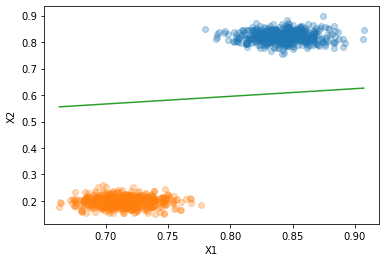

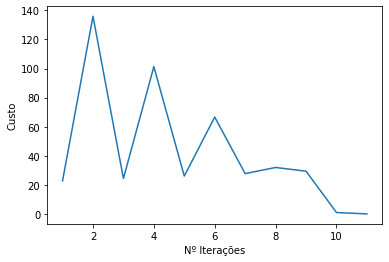

In [10]:
percep = PerceptronMulticlasse(DescidaGradiente(cost=SmoothedSurrogate()))
percep.fit(Xtr,ytr)
ypred = percep.predict(Xte)
print(sum(ypred==yte)/len(ypred))

plotDataSet(X, y)

if percep.w.shape[1] == 1:
    plotHiperplano(X,y,percep.w[1:], percep.w[0])
else:
    for i in range(percep.w.shape[1]):
        plotHiperplano(X,y,percep.w[1:,i], percep.w[0,i])
plt.show() 

PlotCusto(percep.training_algorithm.custos)

# AULA 6

Quanto temos uma situação em que a solução não é linearmente separável, precisamos criar uma camada oculta com pelo menos 2 neuronios, cuja função de ativação seja não linear.

Vamos criar uma nova função de plot para mostrar as regiões e não exatamente os pontos.

In [34]:
def define_axes(X):
    '''
    A função retorna os eixos com a margem de 0.1
    O vetor será o mínimo até o máximo de cada um; esses são os eixos em que faremos a distribuição.
    '''
    #o mínimo e máximo da característica 1
    min1 = X[:,0].min()
    max1 = X[:,0].max() 

    min2 = X[:,1].min()
    max2 = X[:,1].max() 

    #colocando margem para baixo e margem pra cima de 10%
    return [min1-margem, max1+margem, min2-margem, max2+margem] #margem idel é .1 é o mesmo que 0.1

def plotPredictions(clf, X):
    '''
    Recebe um classificador e a matriz de características.
    '''
    axes = define_axes(X)# 
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0,x1 = np.meshgrid(x0s, x1s) #está fazendo a distribuição nxn, gerando duas matrizes
    X_ = np.c_[x0.ravel(), x1.ravel()] #c_ = cópia
    ypred  = clf.predict(X_).reshape(x0.shape)
    plt.contourf(x0,x1,ypred,cmap=plt.cm.brg, alpha=0.2)

Testando um classificador qualquer com a base XOR definida no início.

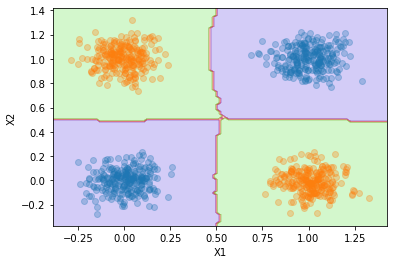

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

def tanh(a):
    '''
    Definição da tangente hiperbólica.
    '''
    return expit(a)*2-1

#outra forma, definindo como função anônima
#tanh = lambda a: expit(a)*2-1

X,y = criaDatasetXOR()

knn = KNeighborsClassifier()
knn.fit(X,y)

plotDataSet(X,y)
plotPredictions(knn, X)


In [13]:
class ELM(BaseEstimator, ClassifierMixin):
    '''
    Extreme Learning Machine - ELM
    Definição da rede neural single hidden layer (uma camada oculta).
    Inicialmente não passaremos o algoritmo de treinamento como parâmetro. Será sempre a PseudoInversa. Iremos generalizar depois.
    '''
    def __init__(self, n_hidden=10, regularization=0):
        self.n_hidden = n_hidden
        self.activation = tanh
        self.training_algorithm = PseudoInversa(regularization)
        self.wih = None #w de entrada da camada h 'w in'
        self.who = None #w de saída da camada h 'w out'
    
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1

    def fit(self, X, y):
        Xb = ELM.includeBias(X)
        
        #treinando os coeficientes de entrada da camada H -> wih
        self.wih = np.random.uniform(-1,1,size=(Xb.shape[1], self.n_hidden))
        
        H = self.activation(Xb @ self.wih) #@ é multiplicação de matrizes; H é a camada oculta
        Hb = ELM.includeBias(H) #H com bias, novas características

        yhot = self.encode_labels(y)

        #treinando os coeficientes de saída da camada de H -> who 
        self.who = self.training_algorithm.getW(Hb, yhot)
    
    def predict(self, X, y=None):
        Xb = ELM.includeBias(X)
        
        H = self.activation(Xb @ self.wih)
        Hb = ELM.includeBias(H)
        a = Hb @ self.who
        
        if self.who.shape[1] == 1:
            idx = np.array(a>0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1)

        ypred = np.array([self.labels[i] for i in idx])
        return ypred

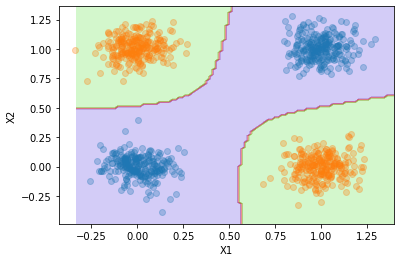

In [14]:
X,y = criaDatasetXOR()

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3)

elm = ELM(regularization=0.1, n_hidden=50)
elm.fit(Xtr,ytr)
ypred = elm.predict(Xte)

plotDataSet(X,y)
plotPredictions(elm, Xte)



AULA QUE VEM...

Criando um MLP genérico que recebe o ELM como algoritmo de treinamento.
Remove o yhot do fit e já retorna o a na linha seguinte no predict. O resto vai pro MLP.

In [15]:
#ELM deixa de ser mixin e será entrada para o MLP

class ELM(TrainingAlgorithm):
    '''
    Extreme Learning Machine - ELM
    ADAPATADO PARA ENTRADA NO MLP
    Definição da rede neural single hidden layer (uma camada oculta).
    Inicialmente não passaremos o algoritmo de treinamento como parâmetro. Será sempre a PseudoInversa. Iremos generalizar depois.
    '''
    def __init__(self, n_hidden=10, regularization=0):
        self.n_hidden = n_hidden
        self.activation = tanh
        self.training_algorithm = PseudoInversa(regularization)
        self.wih = None #w de entrada da camada h 'w in'
        self.who = None #w de saída da camada h 'w out'
    
    @staticmethod
    def includeBias(X):
        bias = np.ones((X.shape[0], 1))
        Xb = np.concatenate((bias, X), axis=1)
        return Xb

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1

    def fit(self, X, y):
        Xb = ELM.includeBias(X)
        
        #treinando os coeficientes de entrada da camada H -> wih
        self.wih = np.random.uniform(-1,1,size=(Xb.shape[1], self.n_hidden))
        
        H = self.activation(Xb @ self.wih) #@ é multiplicação de matrizes; H é a camada oculta
        Hb = ELM.includeBias(H) #H com bias, novas características

        '''ADAPTAÇÃO MLP: 
        > tira o yhot
        yhot = self.encode_labels(y)
        '''

        #treinando os coeficientes de saída da camada de H -> who 
        self.who = self.training_algorithm.getW(Hb, y)
    
    def predict(self, X, y=None):
        Xb = ELM.includeBias(X)
        
        H = self.activation(Xb @ self.wih)
        Hb = ELM.includeBias(H)
        a = Hb @ self.who
        
        '''ADAPTAÇÃO MLP: 
        > tira o if else...
        return ypred
        '''
        return a


    
    


## AULA 7 - MLP

In [76]:
def includeBias(X):
    bias = np.ones((X.shape[0], 1))
    Xb = np.concatenate((bias, X), axis=1)
    return Xb

class FixedWeigths():
    '''
    Utilizaremos inicialmente a quantidade mínima de camadas intermediárias para resolver o problema do XOR.
    ou seja, n_hidden=2
    '''
    def __init__(self):
        self.n_hidden = 2
        self.activation = tanh #utilizando a função tangente hiperbolica
        self.training = PseudoInversa() #será usada para treiar os pesos iniciais usados no fit.

    def fit(self, X, y):
        '''
        Os pesos definidos aqui foram esperimentais definidos pelo Boldt.
        Podemos, no entanto, treinar esses pesos. Por exemplo, utilizar a PseudoInversa ou DescidaGradiente
        para obter esses valores.
        '''
        #coeficientes da camada de entrada da camada oculta
        #Teremos uma matriz 3x2 com a camada de dentrada 
        self.wih = np.array([[1.75, 0.9, -0.9],[-1.75, 0.9, -0.9]]).T #3x2, valores ok, linhas paralelas no grafico impresso
        #self.wih = np.array([[1.75, 0.9, -10.9],[-1.75, 0.9, 5.9]]).T #ajustando alguns valores para "zoar" as linhas e mostrar contornos diferentes

        #coeficientes da camada de saída da camada oculta
        #self.who = np.array([1.234, -0.9, 0.9]) #antes com exemplo de pesos fios definidos pelo Boldt - teste apenas

        #agora outro exemplo: treinando os pesos realmente
        H = self.activation(includeBias(X) @ self.wih)
        Hb = includeBias(H)
        self.who = self.training.getW(Hb, y)

    def predict(self, X, y=None):
        #incluindo o bias na camada intermediaria
        Xb = includeBias(X)
        
        #aplica a funçao de ativação na camada oculta
        H = self.activation(Xb @ self.wih)

        #incluindo o bias tambem na camada 'oculta'. Poruqe ele irá incluir o bias em todas as camadas e mais pra frente irá fazer isso com loop
        Hb = includeBias(H)
        return Hb @ self.who

class MLP(BaseEstimator, ClassifierMixin):
    '''
    Rede neural que será genérico para chamarmos os demais passando apenas o algoritmo de treinamento.
    '''
    def __init__(self, training_algorithm=FixedWeigths()):
        self.training_algorithm = training_algorithm
    
    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1 #tudo entre -1 e 1
    
    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X, yhot)
    
    def predict(self, X, y=None):
        a = self.training_algorithm.predict(X)

        if len(self.labels) <= 2:
            idx = np.array(a>0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1)
        
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

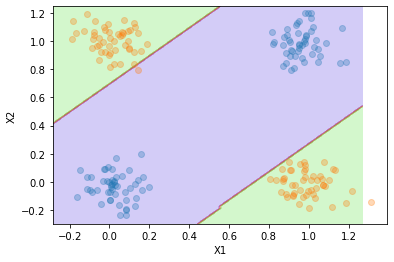

In [72]:
#testanfo o MLP
margem = 0.1 #alterando essa margem a imagem do plotPrediction é mostrada de uma dimensão diferente
X,y = criaDatasetXOR(n=200)

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3)

mlp = MLP()
mlp.fit(Xtr,ytr)
ypred = mlp.predict(Xte)

plotDataSet(X,y)
plotPredictions(mlp, Xte)


Até este ponto trabalhamos o Forward. Ou seja, tratamos um calculo inicial dos pesos de cada camada até sua saída. Visando agora melhorar os pesos, nós iremos voltar no sentido contrário. Partiremos da última camada de saída e calculando os pesos intermediários buscaremos minimizar o erro e encontrar pesos melhores. O algoritmo de treinamento que trata essa volta é chamado de BackPropagation, que definiremos a seguir.

In [69]:
class Backpropagation():
    '''
    Algoritmo de treinamento que será utilizado na volta para descoberta dos pesos da camada hidden.
    '''
    def __init__(self):
        self.n_hidden = 2
        self.activation = tanh
        self.learning_rate = 0.005
        self.max_iter = 1000

    def fit(self, X, y):
        '''
        Sabemos que 
        '''
        self.Xb = includeBias(X)
        #definindo pesos aleatorios
        self.wih = np.random.uniform(-1, 1, size=(self.Xb.shape[1],self.n_hidden)) #matrix com Xb.shape linhas e n_hidden colunas
        self.who = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1])) #matrix 

        #a ideia aqui é iterar indo e voltando na rede e treinando para encontrar os pesos.
        #a cada iteração um ciclo completo é calculado.
        for _ in range(self.max_iter):
            self.forward()
            self.backward(y)

    def forward(self):
        #pH -> preactivation na camada hidden
        Xb = self.Xb
        self.pH = Xb @ self.wih
        self.H = self.activation(self.pH)
        self.Hb = includeBias(self.H)
        self.py = self.Hb @ self.who

    def backward(self, y):
        ho_delta = y - self.py
        #gradiente de saída da camada H
        ho_grad = self.Hb.T @ ho_delta

        #pulo do gato
        #função da tangente hiperbolica equivalente a (1 - tanh(H)²), ou (1 - H²)
        #derivada da função de ativação. Nesse ponto é preciso conhecer sempre a função de ativação pra que sua derivada seja usada no backpropagation
        tanh_grad = (1 - np.square(tanh(self.pH))) 
        ih_delta = (ho_delta @ self.who[1:,:].T)*tanh_grad #self.who precisou tirar o bias, pois na volta ele não existe na camada

        #
        ih_grad = self.Xb.T @ ih_delta

        self.who += ho_grad * self.learning_rate
        self.wih += ih_grad * self.learning_rate

    def predict(self, X, y=None):
        '''
        Predict definido igual ao FixedWeigths, é foward, então, segue o mesmo algoritmo.
        '''
        #incluindo o bias na camada intermediaria
        Xb = includeBias(X)
        
        #aplica a funçao de ativação na camada oculta
        H = self.activation(Xb @ self.wih)

        #incluindo o bias tambem na camada 'oculta'. Porque ele irá incluir o bias em todas as camadas e mais pra frente irá fazer isso com loop
        Hb = includeBias(H)
        return Hb @ self.who

wih= [[-3.28826212  4.33685736]
 [ 5.11776783 -3.4056969 ]
 [ 4.86021498 -3.26094333]]
who= [[-1.24709961]
 [ 1.9637034 ]
 [ 2.10037688]]


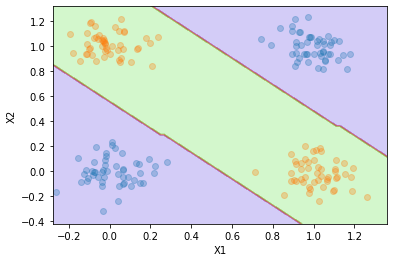

In [88]:
#testanfo o MLP
X,y = criaDatasetXOR(n=200)

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3)

mlp = MLP(training_algorithm=Backpropagation())
mlp.fit(Xtr,ytr)
ypred = mlp.predict(Xte)

plotDataSet(X,y)
plotPredictions(mlp, Xte)

#imprimindo os pesos dos ws para conhecê-los:
print('wih=',mlp.training_algorithm.wih)
print('who=',mlp.training_algorithm.who)


Testando mesmo caso, porém, para n classes com um novo dataset.

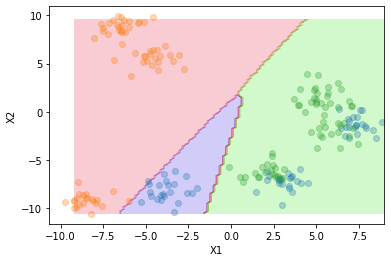

In [102]:
#testanfo o MLP
margem = 0.1
X,y = criaDatasetXOR_Multiclasse(n=200, n_classes=3)

Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.3)

mlp = MLP(training_algorithm=Backpropagation())
mlp.fit(Xtr,ytr)
ypred = mlp.predict(Xte)

plotDataSet(X,y)
plotPredictions(mlp, Xte)
